# Import librerie

In [4]:
import random
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from itertools import combinations_with_replacement

In [11]:
js = JobSequence({"A": 10, "B": 10}, 10, 10)
jobs = []
for i in range(1,10, 2):
    jobs.append(Job("A", i))
for i in range(1,10, 2):
    jobs.append(Job("B", i))
js.set_job_sequence(jobs)

In [12]:
print(js)

(A-1),(A-3),(A-5),(A-7),(A-9),(B-1),(B-3),(B-5),(B-7),(B-9)


In [3]:
assert sum([1, 2, 3]) == 6, "Should be 6"

# Implementazione local search (Job - JobSequence - Machine)

In [5]:
# un job è associato ad un utente (user) ed ha una certa durata (length)
class Job:
    def __init__(self, user, length):
        self.user = user
        self.length = length
        
    def get_user(self):
        return self.user
    
    def get_length(self):
        return self.length
    
    def __str__(self):
        return "(" + self.user + "-" + str(self.length) + ")"

In [6]:
class JobSequence:
    
    # una sequenza di job (JobSequence) viene inizializzata in modo casuale a partire da un dizionario 
    # user_n_jobs={"utente1": numero_job_utente1, "utente2": numero_job_utente2, ...}
    # ogni job della sequenza avrà una durata compresa tra min_length_job e max_length_job
    # self.jobs è una lista di oggetti Job
    def __init__(self, user_n_jobs, min_length_job, max_length_job):         
        sequence_length = sum(user_n_jobs.values())
        self.jobs = [None] * sequence_length
        job_positions_list = random.sample(range(0, sequence_length), sequence_length)
        for user, n_jobs in user_n_jobs.items():
            for i in range(0,n_jobs): 
                job_position = job_positions_list.pop(0)
                job_length = random.randint(min_length_job, max_length_job)
                self.jobs[job_position] = Job(user, job_length)
     
    def set_job_sequence(self, jobs):
        self.jobs = jobs
    
    def get_job_sequence(self):
        return self.jobs
    
    # ordina self.jobs in base alla durata dei job, con reverse=False in ordine crescente di durata
    # mentre con reverse=True in ordine decrescente di durata
    def order_jobs_sequence(self, reverse=False):
        self.jobs.sort(key=lambda x: x.get_length(), reverse=reverse)      
    
    def switch_two_jobs(self, pos1, pos2):
        tmp = self.jobs[pos1]
        self.jobs[pos1] = self.jobs[pos2]
        self.jobs[pos2] = tmp
    
    # permette di ordinare i job in maniera tale da ottenere la peggior sequenza per l'utente specificato (user)
    # la sequenza peggiore è quella per cui tutti i job di user sono messi alla fine, inoltre,
    # i job sono in ordine descrescente di durata
    def make_worst(self, user):
        self.order_jobs_sequence(True)
        jobs_of_user = [x for x in self.jobs if x.get_user() == user]
        jobs_of_other_user = [x for x in self.jobs if x.get_user() != user]
        self.jobs = jobs_of_other_user + jobs_of_user
    
    # permette di ordinare i job in maniera tale da ottenere la miglior sequenza per l'utente specificato (user)
    # la sequenza migliore è quella per cui tutti i job di user sono messi all'inizio, inoltre,
    # i job sono in ordine crescente di durata
    def make_best(self, user):
        self.order_jobs_sequence()
        jobs_of_user = [x for x in self.jobs if x.get_user() == user]
        jobs_of_other_user = [x for x in self.jobs if x.get_user() != user]
        self.jobs = jobs_of_user + jobs_of_other_user
        
    # restituisce il tempo di completamente per un job all'inteno della sequenza (job in posizione pos_job)
    def get_waiting_time(self, pos_job):
        return sum([x.get_length() for x in self.jobs][:pos_job+1])
    
    # calcola la funzione obiettivo per un utente
    def fo(self, user):
        return sum([self.get_waiting_time(self.jobs.index(x)) for x in self.jobs if x.get_user() == user])
    
    # calcola la funzione obiettivo normalizzata per un utente
    def fo_norm(self, user):
        best_sequence = copy.deepcopy(self)
        best_sequence.make_best(user)
        worst_sequence = copy.deepcopy(self)
        worst_sequence.make_worst(user)
        
        bs = best_sequence.fo(user)
        ws = worst_sequence.fo(user)
                
        return (self.fo(user) - bs) / (ws - bs)
    
    def __str__(self):
        return ','.join(map(str, self.jobs))

In [4]:
class Machine:
    
    def __init__(self, user_n_jobs, min_length_job, max_length_job):
        self.x = JobSequence(user_n_jobs, min_length_job, max_length_job)
        self.x.order_jobs_sequence()
        self.users = list(user_n_jobs.keys())

    def get_sequence(self):
        return self.x
    
    def set_sequence(self, x):
        self.x = x
    
    # restituisce la lista delle posizioni dei job di un determinato utente (user)
    def get_position_of_jobs_user(self, user):
        return [self.x.get_job_sequence().index(job) for job in self.x.get_job_sequence() if job.get_user() == user]
    
    # restituisce le posizioni dei job che permettono di decrementare la fo_normalizzata facendo lo switch
    # con un dato job (position) all'interno della sequenza
    def index_of_jobs_to_decrease_fo(self, position, user):
        position_of_jobs_user = self.get_position_of_jobs_user(user)
        if position == position_of_jobs_user[0]:
            return list(range(0,position))
        else:
            tmp = [pos for pos in position_of_jobs_user if pos < position]
            return list(range(tmp[-1]+1,position))
    
    # restituisce le posizioni dei job che permettono di incrementare la fo_normalizzata facendo lo switch
    # con un dato job (position) all'interno della sequenza
    def index_of_jobs_to_increase_fo(self, position, user):
        position_of_jobs_user = self.get_position_of_jobs_user(user)
        if position == position_of_jobs_user[-1]:
            return list(range(position+1,len(self.x.get_job_sequence())))
        else:
            tmp = [pos for pos in position_of_jobs_user if pos > position]
            return list(range(position+1,tmp[0]))
    
    # restituisce il vicinato ottenuto scambiando il job in position con i job presenti in index_of_jobs
    def make_neighborhood(self, position, index_of_jobs):
        neighbors = []
        for i in index_of_jobs:
            y = copy.deepcopy(self.x)
            y.switch_two_jobs(position, i)
            neighbors.append(y)
        return neighbors 
    
    # restituisce il vicinato della soluzione attuale self.x, tenendo conto dell'utente (user) che ha
    # fo_normalizzata più alta
    def neighborhood(self, user, increase=False):
        list_of_neighbors = []
        for position in self.get_position_of_jobs_user(user):
            if increase:
                index_of_jobs = self.index_of_jobs_to_increase_fo(position, self.x.get_job_sequence()[position].get_user())
            else:
                index_of_jobs = self.index_of_jobs_to_decrease_fo(position, self.x.get_job_sequence()[position].get_user())
            list_of_neighbors.extend(self.make_neighborhood(position, index_of_jobs))
        return list_of_neighbors
    
    def get_info_sequence(self):
        x = copy.deepcopy(self.x)
        x_fo = {}
        x_fo_norm = {}
        for user in self.users:
            x_fo_norm[user] = self.x.fo_norm(user)
            x_fo[user] = self.x.fo(user)
        return (x, x_fo, x_fo_norm)
            
    def local_search_steepest_descent(self):
        
        steps = 0
        steps_sequence = []
        x, x_fo, x_fo_norm = self.get_info_sequence()
        steps_sequence.append((x, x_fo, x_fo_norm))
        print(f"Step: {steps}\nFunzione obiettivo: {x_fo}={sum(x_fo.values())}\nFunzione obiettivo normalizzata{x_fo_norm}\n")
        stop = False

        while not stop:

            x, x_fo, x_fo_norm = self.get_info_sequence()
            user_with_max_fo_norm = max(x_fo_norm, key=x_fo_norm.get)
                        
            neighborhood = self.neighborhood(user_with_max_fo_norm)
            neighbors = {}
            for y in neighborhood:
                neighbors[y] = {}         
                for user in self.users:
                    neighbors[y][user] = y.fo_norm(user)
                       
            tmp = {k: max(v.values()) for k, v in neighbors.items()}
            y = min(tmp, key=tmp.get)
            
            stop = True        
            if max(neighbors[y].values()) < max(x_fo_norm.values()):
                self.x = y
                steps += 1    
                x, x_fo, x_fo_norm = self.get_info_sequence()
                steps_sequence.append((x, x_fo, x_fo_norm))
                
                print(f"Grandezza vicinato: {len(neighborhood)}\n\n")
                
                print(f"Step: {steps}\nFunzione obiettivo: {x_fo}={sum(x_fo.values())}\nFunzione obiettivo normalizzata{x_fo_norm}\n")
                stop = False
                
        return steps_sequence
        
        
    def local_search_first_improvement(self):
        
        steps = 0
        steps_sequence = []
        x, x_fo, x_fo_norm = self.get_info_sequence()
        steps_sequence.append((x, x_fo, x_fo_norm))
        print(f"Step: {steps}\nFunzione obiettivo: {x_fo}={sum(x_fo.values())}\nFunzione obiettivo normalizzata{x_fo_norm}\n")
        stop = False
        
        while not stop:
            
            x, x_fo, x_fo_norm = self.get_info_sequence()
            user_with_max_fo_norm = max(x_fo_norm, key=x_fo_norm.get)
                 
            stop = True 
            index = 0
            neighborhood = self.neighborhood(user_with_max_fo_norm)   
            for y in neighborhood:    
                index += 1
                y_fo_norm = {}
                for user in self.users:
                    y_fo_norm[user] = y.fo_norm(user)
                if max(y_fo_norm.values()) < max(x_fo_norm.values()):
                    self.x = y
                    steps += 1    
                    x, x_fo, x_fo_norm = self.get_info_sequence()
                    steps_sequence.append((x, x_fo, x_fo_norm))
                    
                    print(f"Grandezza vicinato: {len(neighborhood)}\nNumero vicini considerati: {index}\n\n")
                    
                    print(f"Step: {steps}\nFunzione obiettivo: {x_fo}={sum(x_fo.values())}\nFunzione obiettivo normalizzata: {x_fo_norm}\n")
                    stop = False 
                    break            
        
        return steps_sequence
    
    def __str__(self):
        return str(self.x)

In [5]:
user_n_jobs = {"A": 50, "B": 50}
min_job_length = 1
max_job_length = 100

m = Machine(user_n_jobs, min_job_length, max_job_length)

start = time.time()
steps = m.local_search_first_improvement()
# steps = m.local_search_steepest_descent()
end = time.time()

print((end-start), "(s)")

Step: 0
Funzione obiettivo: {'A': 72692, 'B': 79883}=152575
Funzione obiettivo normalizzata{'A': 0.20786523882202818, 'B': 0.2565141614883881}

Grandezza vicinato: 50
Numero vicini considerati: 1


Step: 1
Funzione obiettivo: {'A': 72693, 'B': 79882}=152575
Funzione obiettivo normalizzata: {'A': 0.2078714939825356, 'B': 0.2565080029807177}

Grandezza vicinato: 50
Numero vicini considerati: 1


Step: 2
Funzione obiettivo: {'A': 72695, 'B': 79881}=152576
Funzione obiettivo normalizzata: {'A': 0.20788400430355042, 'B': 0.2565018444730473}

Grandezza vicinato: 50
Numero vicini considerati: 1


Step: 3
Funzione obiettivo: {'A': 72753, 'B': 79859}=152612
Funzione obiettivo normalizzata: {'A': 0.2082468036129807, 'B': 0.256366357304298}

Grandezza vicinato: 50
Numero vicini considerati: 1


Step: 4
Funzione obiettivo: {'A': 72805, 'B': 79837}=152642
Funzione obiettivo normalizzata: {'A': 0.20857207195936647, 'B': 0.25623087013554874}

Grandezza vicinato: 50
Numero vicini considerati: 1


Step

# Codice test algoritmo

In [7]:
class TestMachine:
        
    def __init__(self, users, n_jobs, lengths):
        self.users = users
        self.n_jobs = n_jobs
        self.lengths = lengths
        
    def extract_info(self, steps, start, end, user_n_jobs, length):
        fo_start = steps[0][1]
        fo_end = steps[-1][1]
        fo_norm_start = steps[0][2]
        fo_norm_end = steps[-1][2]    

        user_n_jobs = {"#j-"+k: v for k,v in user_n_jobs.items()}
        fo_start = {"fo-S-"+k: v for k,v in fo_start.items()}
        fo_end = {"fo-E-"+k: v for k,v in fo_end.items()}
        fo_norm_start = {"foN-S-"+k: v for k,v in fo_norm_start.items()}
        fo_norm_end = {"foN-E-"+k: v for k,v in fo_norm_end.items()}

        user_n_jobs.update({"len":length, "#steps":len(steps),"t(ms)":round((end-start)/1000000)})
        user_n_jobs.update(fo_start)
        user_n_jobs.update(fo_end)
        sum_start = sum(fo_start.values())
        sum_end = sum(fo_end.values())
        user_n_jobs.update({"sum-S":sum_start, "sum-E":sum_end, "diff_fo":sum_end-sum_start})
        user_n_jobs.update(fo_norm_start)
        user_n_jobs.update(fo_norm_end)
        start_max_fo_norm = max(fo_norm_start.values())
        start_min_fo_norm = min(fo_norm_start.values())
        end_max_fo_norm = max(fo_norm_end.values())
        end_min_fo_norm = min(fo_norm_end.values())
        diff_S = start_max_fo_norm-start_min_fo_norm
        diff_E = end_max_fo_norm-end_min_fo_norm
        user_n_jobs.update({"max-diff-S":diff_S, "max-diff-E":diff_E})

        return user_n_jobs
        
    def run_test(self):
        
        data1 = []
        data2 = []
        for length in self.lengths:
            #for list_n_jobs in list(combinations_with_replacement(self.n_jobs, len(self.users))):
            #    user_n_jobs = {self.users[i]: list_n_jobs[i] for i in range(len(list_n_jobs))}
            for n in self.n_jobs:
                
                user_n_jobs = {self.users[i]: n for i in range(len(self.users))}
                   
                print(f"Durata ({length}) - User-nJobs({user_n_jobs})\n")

                m = Machine(user_n_jobs, 1, length)
                
                x = m.get_sequence()

                print("local_search_first_improvement")
                start = time.time_ns()
                steps = m.local_search_first_improvement()
                end = time.time_ns()
                tmp_dict = copy.deepcopy(user_n_jobs)
                data1.append(self.extract_info(steps, start, end, tmp_dict, length))

                m.set_sequence(x)

                print("local_search_steepest_descent")
                start = time.time_ns()
                steps = m.local_search_steepest_descent()
                end = time.time_ns()
                tmp_dict = copy.deepcopy(user_n_jobs)
                data2.append(self.extract_info(steps, start, end, tmp_dict, length))
                    
        df1 = pd.DataFrame(data1)
        df2 = pd.DataFrame(data2)
        return (df1, df2)     


In [15]:
users = ["A", "B"]
n_jobs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200, 220, 250]
lengths = [100]

t = TestMachine(users, n_jobs, lengths)

result = t.run_test()

print("local_search_first_improvement")
result[0].to_csv(".\\local_search_first_improvement.csv", index=False)
display(result[0])

print("local_search_steepest_descent")
result[1].to_csv(".\\local_search_steepest_descent.csv", index=False)
display(result[1])

Durata (100) - User-nJobs({'A': 10, 'B': 10})

local_search_first_improvement
Step: 0
Funzione obiettivo: {'A': 4615, 'B': 3243}=7858
Funzione obiettivo normalizzata{'A': 0.334725345326052, 'B': 0.19638914144694117}

Grandezza vicinato: 9
Numero vicini considerati: 1


Step: 1
Funzione obiettivo: {'A': 4587, 'B': 3334}=7921
Funzione obiettivo normalizzata: {'A': 0.3302280758111147, 'B': 0.20820885829328484}

Grandezza vicinato: 9
Numero vicini considerati: 1


Step: 2
Funzione obiettivo: {'A': 4522, 'B': 3535}=8057
Funzione obiettivo normalizzata: {'A': 0.3197879858657244, 'B': 0.2343161449538901}

Grandezza vicinato: 9
Numero vicini considerati: 1


Step: 3
Funzione obiettivo: {'A': 4363, 'B': 3922}=8285
Funzione obiettivo normalizzata: {'A': 0.2942499196916158, 'B': 0.2845824133004286}

Grandezza vicinato: 9
Numero vicini considerati: 7


Step: 4
Funzione obiettivo: {'A': 4306, 'B': 3979}=8285
Funzione obiettivo normalizzata: {'A': 0.2850947638933505, 'B': 0.2919859722041824}

Grande

local_search_steepest_descent
Step: 0
Funzione obiettivo: {'A': 35441, 'B': 34725}=70166
Funzione obiettivo normalizzata{'A': 0.28776107685513813, 'B': 0.27418876137712705}

Grandezza vicinato: 29


Step: 1
Funzione obiettivo: {'A': 35173, 'B': 34999}=70172
Funzione obiettivo normalizzata{'A': 0.2833777661471026, 'B': 0.27870663500857407}

Grandezza vicinato: 29


Step: 2
Funzione obiettivo: {'A': 35037, 'B': 35135}=70172
Funzione obiettivo normalizzata{'A': 0.28115339951914425, 'B': 0.2809490832344018}

Durata (100) - User-nJobs({'A': 40, 'B': 40})

local_search_first_improvement
Step: 0
Funzione obiettivo: {'A': 59559, 'B': 58694}=118253
Funzione obiettivo normalizzata{'A': 0.2732455532455532, 'B': 0.2641843971631206}

Grandezza vicinato: 39
Numero vicini considerati: 1


Step: 1
Funzione obiettivo: {'A': 59550, 'B': 58712}=118262
Funzione obiettivo normalizzata: {'A': 0.27316239316239316, 'B': 0.26435149084697934}

Grandezza vicinato: 39
Numero vicini considerati: 1


Step: 2
Funzio

Grandezza vicinato: 50
Numero vicini considerati: 1


Step: 29
Funzione obiettivo: {'A': 74849, 'B': 79575}=154424
Funzione obiettivo normalizzata: {'A': 0.24067672109739816, 'B': 0.24058144139816012}

local_search_steepest_descent
Step: 0
Funzione obiettivo: {'A': 65132, 'B': 83666}=148798
Funzione obiettivo normalizzata{'A': 0.1840287291658165, 'B': 0.26714103005239204}

Grandezza vicinato: 50


Step: 1
Funzione obiettivo: {'A': 65416, 'B': 83391}=148807
Funzione obiettivo normalizzata{'A': 0.1856843872607603, 'B': 0.2653556751562997}

Grandezza vicinato: 50


Step: 2
Funzione obiettivo: {'A': 65802, 'B': 83021}=148823
Funzione obiettivo normalizzata{'A': 0.18793468312219805, 'B': 0.26295356129610276}

Grandezza vicinato: 50


Step: 3
Funzione obiettivo: {'A': 66188, 'B': 82651}=148839
Funzione obiettivo normalizzata{'A': 0.1901849789836358, 'B': 0.26055144743590575}

Grandezza vicinato: 50


Step: 4
Funzione obiettivo: {'A': 66582, 'B': 82281}=148863
Funzione obiettivo normalizzata{

Grandezza vicinato: 59
Numero vicini considerati: 1


Step: 25
Funzione obiettivo: {'A': 130706, 'B': 136245}=266951
Funzione obiettivo normalizzata: {'A': 0.28506722035610355, 'B': 0.28753865712940846}

Grandezza vicinato: 59
Numero vicini considerati: 1


Step: 26
Funzione obiettivo: {'A': 130719, 'B': 136233}=266952
Funzione obiettivo normalizzata: {'A': 0.28511932915928456, 'B': 0.2874858678773002}

Grandezza vicinato: 59
Numero vicini considerati: 1


Step: 27
Funzione obiettivo: {'A': 130734, 'B': 136221}=266955
Funzione obiettivo normalizzata: {'A': 0.28517945470141653, 'B': 0.2874330786251919}

Grandezza vicinato: 59
Numero vicini considerati: 1


Step: 28
Funzione obiettivo: {'A': 130752, 'B': 136209}=266961
Funzione obiettivo normalizzata: {'A': 0.2852516053519749, 'B': 0.28738028937308363}

Grandezza vicinato: 59
Numero vicini considerati: 1


Step: 29
Funzione obiettivo: {'A': 130776, 'B': 136197}=266973
Funzione obiettivo normalizzata: {'A': 0.2853478062193861, 'B': 0.2873

Grandezza vicinato: 70
Numero vicini considerati: 1


Step: 8
Funzione obiettivo: {'A': 183164, 'B': 188938}=372102
Funzione obiettivo normalizzata: {'A': 0.25595466604021155, 'B': 0.2720850489949929}

Grandezza vicinato: 70
Numero vicini considerati: 1


Step: 9
Funzione obiettivo: {'A': 183309, 'B': 188874}=372183
Funzione obiettivo normalizzata: {'A': 0.25637007454433985, 'B': 0.27190140744035235}

Grandezza vicinato: 70
Numero vicini considerati: 1


Step: 10
Funzione obiettivo: {'A': 183550, 'B': 188793}=372343
Funzione obiettivo normalizzata: {'A': 0.25706051212706343, 'B': 0.2716689860977604}

Grandezza vicinato: 70
Numero vicini considerati: 1


Step: 11
Funzione obiettivo: {'A': 183915, 'B': 188649}=372564
Funzione obiettivo normalizzata: {'A': 0.2581061956029726, 'B': 0.27125579259981925}

Grandezza vicinato: 70
Numero vicini considerati: 1


Step: 12
Funzione obiettivo: {'A': 184332, 'B': 188505}=372837
Funzione obiettivo normalizzata: {'A': 0.2593008531631209, 'B': 0.270842

Grandezza vicinato: 80
Numero vicini considerati: 1


Step: 16
Funzione obiettivo: {'A': 211912, 'B': 224044}=435956
Funzione obiettivo normalizzata: {'A': 0.2430570476078263, 'B': 0.2642201224064713}

Grandezza vicinato: 80
Numero vicini considerati: 1


Step: 17
Funzione obiettivo: {'A': 212500, 'B': 223834}=436334
Funzione obiettivo normalizzata: {'A': 0.2444154890042486, 'B': 0.2637207953091786}

Grandezza vicinato: 80
Numero vicini considerati: 1


Step: 18
Funzione obiettivo: {'A': 213386, 'B': 223500}=436886
Funzione obiettivo normalizzata: {'A': 0.2464623921968169, 'B': 0.262926627449675}

Grandezza vicinato: 80
Numero vicini considerati: 1


Step: 19
Funzione obiettivo: {'A': 214019, 'B': 223166}=437185
Funzione obiettivo normalizzata: {'A': 0.24792479594500622, 'B': 0.26213245959017134}

Grandezza vicinato: 80
Numero vicini considerati: 1


Step: 20
Funzione obiettivo: {'A': 214951, 'B': 222832}=437783
Funzione obiettivo normalizzata: {'A': 0.25007797176382524, 'B': 0.2613382

Grandezza vicinato: 88
Numero vicini considerati: 1


Step: 12
Funzione obiettivo: {'A': 282775, 'B': 263948}=546723
Funzione obiettivo normalizzata: {'A': 0.26039835527556676, 'B': 0.23853039810091492}

Grandezza vicinato: 88
Numero vicini considerati: 1


Step: 13
Funzione obiettivo: {'A': 282682, 'B': 264153}=546835
Funzione obiettivo normalizzata: {'A': 0.26022294315138256, 'B': 0.23889822920722528}

Grandezza vicinato: 88
Numero vicini considerati: 1


Step: 14
Funzione obiettivo: {'A': 282589, 'B': 264344}=546933
Funzione obiettivo normalizzata: {'A': 0.2600475310271983, 'B': 0.23924094014042177}

Grandezza vicinato: 88
Numero vicini considerati: 1


Step: 15
Funzione obiettivo: {'A': 282464, 'B': 264645}=547109
Funzione obiettivo normalizzata: {'A': 0.2598117620430797, 'B': 0.23978102386237016}

Grandezza vicinato: 88
Numero vicini considerati: 1


Step: 16
Funzione obiettivo: {'A': 282339, 'B': 265026}=547365
Funzione obiettivo normalizzata: {'A': 0.2595759930589611, 'B': 0.240

Grandezza vicinato: 99
Numero vicini considerati: 1


Step: 15
Funzione obiettivo: {'A': 275040, 'B': 306969}=582009
Funzione obiettivo normalizzata: {'A': 0.2138580561533331, 'B': 0.2524227338760609}

Grandezza vicinato: 99
Numero vicini considerati: 1


Step: 16
Funzione obiettivo: {'A': 275428, 'B': 306797}=582225
Funzione obiettivo normalizzata: {'A': 0.21446841846943784, 'B': 0.25213911282676194}

Grandezza vicinato: 99
Numero vicini considerati: 1


Step: 17
Funzione obiettivo: {'A': 275912, 'B': 306625}=582537
Funzione obiettivo normalizzata: {'A': 0.21522979826581592, 'B': 0.251855491777463}

Grandezza vicinato: 99
Numero vicini considerati: 1


Step: 18
Funzione obiettivo: {'A': 276300, 'B': 306453}=582753
Funzione obiettivo normalizzata: {'A': 0.21584016058192068, 'B': 0.25157187072816406}

Grandezza vicinato: 99
Numero vicini considerati: 1


Step: 19
Funzione obiettivo: {'A': 276792, 'B': 306247}=583039
Funzione obiettivo normalizzata: {'A': 0.21661412516832157, 'B': 0.2512

Grandezza vicinato: 99


Step: 15
Funzione obiettivo: {'A': 286177, 'B': 295609}=581786
Funzione obiettivo normalizzata{'A': 0.23137765696379356, 'B': 0.23369055294561897}

Grandezza vicinato: 99


Step: 16
Funzione obiettivo: {'A': 286996, 'B': 294925}=581921
Funzione obiettivo normalizzata{'A': 0.2326660248423755, 'B': 0.23256266458677896}

Grandezza vicinato: 100


Step: 17
Funzione obiettivo: {'A': 286962, 'B': 294959}=581921
Funzione obiettivo normalizzata{'A': 0.2326125394847787, 'B': 0.2326187292128032}

Grandezza vicinato: 99


Step: 18
Funzione obiettivo: {'A': 286964, 'B': 294958}=581922
Funzione obiettivo normalizzata{'A': 0.23261568568228438, 'B': 0.23261708025321423}

Durata (100) - User-nJobs({'A': 120, 'B': 120})

local_search_first_improvement
Step: 0
Funzione obiettivo: {'A': 600309, 'B': 477957}=1078266
Funzione obiettivo normalizzata{'A': 0.3198064534208486, 'B': 0.21646274490994988}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 1
Funzione obiettivo: 

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 37
Funzione obiettivo: {'A': 588601, 'B': 504965}=1093566
Funzione obiettivo normalizzata: {'A': 0.3076547838117508, 'B': 0.24237032063119018}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 38
Funzione obiettivo: {'A': 587917, 'B': 506468}=1094385
Funzione obiettivo normalizzata: {'A': 0.30694486392683257, 'B': 0.24381208182450417}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 39
Funzione obiettivo: {'A': 587116, 'B': 508109}=1095225
Funzione obiettivo normalizzata: {'A': 0.3061135103773888, 'B': 0.2453862202930526}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 40
Funzione obiettivo: {'A': 586275, 'B': 510713}=1096988
Funzione obiettivo normalizzata: {'A': 0.3052406410452013, 'B': 0.247884121921389}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 41
Funzione obiettivo: {'A': 585434, 'B': 512543}=1097977
Funzione obiettivo normalizzata: {'A': 0.3043677717130138, 'B':

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 78
Funzione obiettivo: {'A': 569838, 'B': 551833}=1121671
Funzione obiettivo normalizzata: {'A': 0.2881807680212229, 'B': 0.28732871291877504}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 79
Funzione obiettivo: {'A': 569832, 'B': 551864}=1121696
Funzione obiettivo normalizzata: {'A': 0.2881745406538113, 'B': 0.2873584498429219}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 80
Funzione obiettivo: {'A': 569826, 'B': 551897}=1121723
Funzione obiettivo normalizzata: {'A': 0.28816831328639975, 'B': 0.28739010527830405}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 81
Funzione obiettivo: {'A': 569820, 'B': 551930}=1121750
Funzione obiettivo normalizzata: {'A': 0.2881620859189882, 'B': 0.2874217607136862}

Grandezza vicinato: 120
Numero vicini considerati: 1


Step: 82
Funzione obiettivo: {'A': 569814, 'B': 551964}=1121778
Funzione obiettivo normalizzata: {'A': 0.2881558585515766, 'B'

Grandezza vicinato: 120


Step: 24
Funzione obiettivo: {'A': 582449, 'B': 497283}=1079732
Funzione obiettivo normalizzata{'A': 0.301269656425761, 'B': 0.23500131897647425}

Grandezza vicinato: 120


Step: 25
Funzione obiettivo: {'A': 581089, 'B': 498733}=1079822
Funzione obiettivo normalizzata{'A': 0.29985811981247323, 'B': 0.23639223962205327}

Grandezza vicinato: 120


Step: 26
Funzione obiettivo: {'A': 579629, 'B': 500449}=1080078
Funzione obiettivo normalizzata{'A': 0.2983427937423261, 'B': 0.23803832226192476}

Grandezza vicinato: 120


Step: 27
Funzione obiettivo: {'A': 578169, 'B': 502133}=1080302
Funzione obiettivo normalizzata{'A': 0.29682746767217894, 'B': 0.2396537087220317}

Grandezza vicinato: 104


Step: 28
Funzione obiettivo: {'A': 577835, 'B': 502477}=1080312
Funzione obiettivo normalizzata{'A': 0.29648081088626854, 'B': 0.23998369265450012}

Grandezza vicinato: 104


Step: 29
Funzione obiettivo: {'A': 577501, 'B': 502826}=1080327
Funzione obiettivo normalizzata{'A': 0.

Grandezza vicinato: 150
Numero vicini considerati: 1


Step: 16
Funzione obiettivo: {'A': 686888, 'B': 690579}=1377467
Funzione obiettivo normalizzata: {'A': 0.2432543269976428, 'B': 0.24048436242874505}

Grandezza vicinato: 150
Numero vicini considerati: 1


Step: 17
Funzione obiettivo: {'A': 686770, 'B': 690841}=1377611
Funzione obiettivo normalizzata: {'A': 0.24317188803391454, 'B': 0.2406712372539957}

Grandezza vicinato: 150
Numero vicini considerati: 1


Step: 18
Funzione obiettivo: {'A': 686640, 'B': 691104}=1377744
Funzione obiettivo normalizzata: {'A': 0.2430810654467563, 'B': 0.24085882534193814}

Grandezza vicinato: 150
Numero vicini considerati: 1


Step: 19
Funzione obiettivo: {'A': 686409, 'B': 691543}=1377952
Funzione obiettivo normalizzata: {'A': 0.24291968069572897, 'B': 0.24117194766363673}

Grandezza vicinato: 150
Numero vicini considerati: 1


Step: 20
Funzione obiettivo: {'A': 686178, 'B': 691982}=1378160
Funzione obiettivo normalizzata: {'A': 0.2427582959447016, '

Grandezza vicinato: 169
Numero vicini considerati: 1


Step: 17
Funzione obiettivo: {'A': 859036, 'B': 902450}=1761486
Funzione obiettivo normalizzata: {'A': 0.23691202222088037, 'B': 0.24763706391076845}

Grandezza vicinato: 169
Numero vicini considerati: 1


Step: 18
Funzione obiettivo: {'A': 859247, 'B': 902365}=1761612
Funzione obiettivo normalizzata: {'A': 0.23702577915412285, 'B': 0.24758883493548098}

Grandezza vicinato: 169
Numero vicini considerati: 1


Step: 19
Funzione obiettivo: {'A': 859623, 'B': 902239}=1761862
Funzione obiettivo normalizzata: {'A': 0.23722849293089618, 'B': 0.24751734257211366}

Grandezza vicinato: 169
Numero vicini considerati: 1


Step: 20
Funzione obiettivo: {'A': 860020, 'B': 902102}=1762122
Funzione obiettivo normalizzata: {'A': 0.23744252848775524, 'B': 0.24743960881194443}

Grandezza vicinato: 169
Numero vicini considerati: 1


Step: 21
Funzione obiettivo: {'A': 860339, 'B': 901965}=1762304
Funzione obiettivo normalizzata: {'A': 0.2376145117185815

Grandezza vicinato: 169


Step: 7
Funzione obiettivo: {'A': 865779, 'B': 895171}=1760950
Funzione obiettivo normalizzata{'A': 0.24054739189317415, 'B': 0.24350696142703296}

Grandezza vicinato: 169


Step: 8
Funzione obiettivo: {'A': 867034, 'B': 893968}=1761002
Funzione obiettivo normalizzata{'A': 0.2412240030363936, 'B': 0.2428243795767879}

Grandezza vicinato: 169


Step: 9
Funzione obiettivo: {'A': 868524, 'B': 892568}=1761092
Funzione obiettivo normalizzata{'A': 0.24202731029009636, 'B': 0.24203001998381776}

Grandezza vicinato: 154


Step: 10
Funzione obiettivo: {'A': 868526, 'B': 892566}=1761092
Funzione obiettivo normalizzata{'A': 0.2420283885548664, 'B': 0.24202888518439925}

Durata (100) - User-nJobs({'A': 200, 'B': 200})

local_search_first_improvement
Step: 0
Funzione obiettivo: {'A': 1411370, 'B': 1299500}=2710870
Funzione obiettivo normalizzata{'A': 0.2666596028162219, 'B': 0.23300498535006778}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 1
Funzione obiet

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 37
Funzione obiettivo: {'A': 1406862, 'B': 1309579}=2716441
Funzione obiettivo normalizzata: {'A': 0.26496578165638274, 'B': 0.23667803676331248}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 38
Funzione obiettivo: {'A': 1406473, 'B': 1310436}=2716909
Funzione obiettivo normalizzata: {'A': 0.26481962007005233, 'B': 0.23699034999489804}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 39
Funzione obiettivo: {'A': 1406084, 'B': 1311449}=2717533
Funzione obiettivo normalizzata: {'A': 0.264673458483722, 'B': 0.2373595137097127}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 40
Funzione obiettivo: {'A': 1405695, 'B': 1312111}=2717806
Funzione obiettivo normalizzata: {'A': 0.2645272968973916, 'B': 0.23760076383726184}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 41
Funzione obiettivo: {'A': 1405250, 'B': 1313228}=2718478
Funzione obiettivo normalizzata: {'A': 0.2643600940

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 77
Funzione obiettivo: {'A': 1383920, 'B': 1362623}=2746543
Funzione obiettivo normalizzata: {'A': 0.2563456296934214, 'B': 0.2560086587659072}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 78
Funzione obiettivo: {'A': 1383911, 'B': 1362631}=2746542
Funzione obiettivo normalizzata: {'A': 0.2563422480628893, 'B': 0.25601157417530357}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 79
Funzione obiettivo: {'A': 1383902, 'B': 1362639}=2746541
Funzione obiettivo normalizzata: {'A': 0.25633886643235726, 'B': 0.2560144895846999}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 80
Funzione obiettivo: {'A': 1383893, 'B': 1362648}=2746541
Funzione obiettivo normalizzata: {'A': 0.25633548480182516, 'B': 0.2560177694202708}

Grandezza vicinato: 199
Numero vicini considerati: 1


Step: 81
Funzione obiettivo: {'A': 1383884, 'B': 1362658}=2746542
Funzione obiettivo normalizzata: {'A': 0.25633210317

Grandezza vicinato: 199


Step: 1
Funzione obiettivo: {'A': 1411007, 'B': 1299871}=2710878
Funzione obiettivo normalizzata{'A': 0.2665232103847619, 'B': 0.23314018746082418}

Grandezza vicinato: 199


Step: 2
Funzione obiettivo: {'A': 1410644, 'B': 1300238}=2710882
Funzione obiettivo normalizzata{'A': 0.26638681795330194, 'B': 0.23327393186688242}

Grandezza vicinato: 199


Step: 3
Funzione obiettivo: {'A': 1410096, 'B': 1300798}=2710894
Funzione obiettivo normalizzata{'A': 0.26618091422757173, 'B': 0.2334780105246279}

Grandezza vicinato: 199


Step: 4
Funzione obiettivo: {'A': 1409548, 'B': 1301358}=2710906
Funzione obiettivo normalizzata{'A': 0.26597501050184147, 'B': 0.23368208918237343}

Grandezza vicinato: 199


Step: 5
Funzione obiettivo: {'A': 1408720, 'B': 1302222}=2710942
Funzione obiettivo normalizzata{'A': 0.26566390049289146, 'B': 0.2339969533971808}

Grandezza vicinato: 199


Step: 6
Funzione obiettivo: {'A': 1407798, 'B': 1303174}=2710972
Funzione obiettivo normalizzata{

Grandezza vicinato: 220
Numero vicini considerati: 1


Step: 3
Funzione obiettivo: {'A': 1770561, 'B': 1713418}=3483979
Funzione obiettivo normalizzata: {'A': 0.2582037731399889, 'B': 0.2569769031613699}

Grandezza vicinato: 220
Numero vicini considerati: 1


Step: 4
Funzione obiettivo: {'A': 1770553, 'B': 1713426}=3483979
Funzione obiettivo normalizzata: {'A': 0.25820131682855807, 'B': 0.25697920579342226}

Grandezza vicinato: 220
Numero vicini considerati: 1


Step: 5
Funzione obiettivo: {'A': 1770541, 'B': 1713438}=3483979
Funzione obiettivo normalizzata: {'A': 0.25819763236141186, 'B': 0.25698265974150075}

Grandezza vicinato: 220
Numero vicini considerati: 1


Step: 6
Funzione obiettivo: {'A': 1770519, 'B': 1713490}=3484009
Funzione obiettivo normalizzata: {'A': 0.2581908775049771, 'B': 0.25699762684984107}

Grandezza vicinato: 220
Numero vicini considerati: 1


Step: 7
Funzione obiettivo: {'A': 1770492, 'B': 1713550}=3484042
Funzione obiettivo normalizzata: {'A': 0.25818258745389

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 23
Funzione obiettivo: {'A': 2186252, 'B': 2105523}=4291775
Funzione obiettivo normalizzata: {'A': 0.25947807668764694, 'B': 0.24794304200227316}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 24
Funzione obiettivo: {'A': 2186107, 'B': 2105808}=4291915
Funzione obiettivo normalizzata: {'A': 0.2594431604360823, 'B': 0.248009596996665}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 25
Funzione obiettivo: {'A': 2185942, 'B': 2106123}=4292065
Funzione obiettivo normalizzata: {'A': 0.25940342814981915, 'B': 0.24808315777994022}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 26
Funzione obiettivo: {'A': 2185777, 'B': 2106468}=4292245
Funzione obiettivo normalizzata: {'A': 0.25936369586355595, 'B': 0.2481637243520988}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 27
Funzione obiettivo: {'A': 2185579, 'B': 2106930}=4292509
Funzione obiettivo normalizzata: {'A': 0.2593160171

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 63
Funzione obiettivo: {'A': 2172048, 'B': 2140114}=4312162
Funzione obiettivo normalizzata: {'A': 0.2560577288447248, 'B': 0.2560209501110768}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 64
Funzione obiettivo: {'A': 2172037, 'B': 2140135}=4312172
Funzione obiettivo normalizzata: {'A': 0.2560550800256406, 'B': 0.25602585416329515}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 65
Funzione obiettivo: {'A': 2172026, 'B': 2140157}=4312183
Funzione obiettivo normalizzata: {'A': 0.25605243120655635, 'B': 0.2560309917418096}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 66
Funzione obiettivo: {'A': 2172015, 'B': 2140179}=4312194
Funzione obiettivo normalizzata: {'A': 0.25604978238747217, 'B': 0.25603612932032405}

Grandezza vicinato: 250
Numero vicini considerati: 1


Step: 67
Funzione obiettivo: {'A': 2172004, 'B': 2140201}=4312205
Funzione obiettivo normalizzata: {'A': 0.2560471335

,#j-A,#j-B,len,#steps,t(ms),fo-S-A,fo-S-B,fo-E-A,fo-E-B,sum-S,sum-E,diff_fo,foN-S-A,foN-S-B,foN-E-A,foN-E-B,max-diff-S,max-diff-E
0,10,10,100,7,65,4615,3243,4320,3936,7858,8256,398,0.334725,0.196389,0.287343,0.286401,0.138336,9.425674e-04
1,20,20,100,10,194,18951,11542,17581,15733,30493,33314,2821,0.349834,0.167902,0.295010,0.294691,0.181932,3.191372e-04
2,30,30,100,8,542,35441,34725,35132,35253,70166,70385,219,0.287761,0.274189,0.282707,0.282895,0.013572,1.875518e-04
3,40,40,100,6,654,59559,58694,59305,59410,118253,118715,462,0.273246,0.264184,0.270899,0.270831,0.009061,6.757831e-05
4,50,50,100,30,3025,65132,83666,74849,79575,148798,154424,5626,0.184029,0.267141,0.240677,0.240581,0.083112,9.527970e-05
5,60,60,100,40,4966,110421,145503,131103,136077,255924,267180,11256,0.203757,0.328266,0.286659,0.286800,0.124508,1.410646e-04
6,70,70,100,27,5080,182534,189206,187096,187266,371740,374362,2622,0.254150,0.272854,0.267219,0.267287,0.018704,6.801466e-05
7,80,80,100,38,9674,209889,224820,218289,221362,434709,439651,4942,0.238383,0.266065,0.257790,0.257843,0.027682,5.333406e-05
8,90,90,100,28,10293,283420,262639,279390,272553,546059,551943,5884,0.261615,0.236182,0.254014,0.253970,0.025433,4.339811e-05
9,100,100,100,43,16014,272077,308312,292569,300329,580389,592898,12509,0.209197,0.254637,0.241433,0.241474,0.045440,4.073801e-05


local_search_steepest_descent


,#j-A,#j-B,len,#steps,t(ms),fo-S-A,fo-S-B,fo-E-A,fo-E-B,sum-S,sum-E,diff_fo,foN-S-A,foN-S-B,foN-E-A,foN-E-B,max-diff-S,max-diff-E
0,10,10,100,5,60,4615,3243,4182,3774,7858,7956,98,0.334725,0.196389,0.265178,0.265359,0.138336,1.808529e-04
1,20,20,100,14,876,18951,11542,16466,14269,30493,30735,242,0.349834,0.167902,0.250390,0.250401,0.181932,1.067540e-05
2,30,30,100,3,500,35441,34725,35037,35135,70166,70172,6,0.287761,0.274189,0.281153,0.280949,0.013572,2.043163e-04
3,40,40,100,4,1192,59559,58694,59082,59191,118253,118273,20,0.273246,0.264184,0.268838,0.268798,0.009061,4.002940e-05
4,50,50,100,18,8217,65132,83666,72441,77429,148798,149870,1072,0.184029,0.267141,0.226639,0.226649,0.083112,1.057503e-05
5,60,60,100,22,15523,110421,145503,126910,132222,255924,259132,3208,0.203757,0.328266,0.269851,0.269841,0.124508,1.038947e-05
6,70,70,100,7,7317,182534,189206,185900,186052,371740,371952,212,0.254150,0.272854,0.263793,0.263804,0.018704,1.096786e-05
7,80,80,100,8,14237,209889,224820,216138,219249,434709,435387,678,0.238383,0.266065,0.252820,0.252819,0.027682,1.447224e-06
8,90,90,100,12,27203,283420,262639,276790,269842,546059,546632,573,0.261615,0.236182,0.249110,0.249106,0.025433,3.745334e-06
9,100,100,100,19,49242,272077,308312,286964,294958,580389,581922,1533,0.209197,0.254637,0.232616,0.232617,0.045440,1.394571e-06


# Plot risultati test

In [16]:
df1 = pd.read_csv(".\\local_search_first_improvement.csv")
df2 = pd.read_csv(".\\local_search_steepest_descent.csv")

In [17]:
with pd.option_context('display.float_format',"{:.5f}".format):
    display(df1.head())

,#j-A,#j-B,len,#steps,t(ms),fo-S-A,fo-S-B,fo-E-A,fo-E-B,sum-S,sum-E,diff_fo,foN-S-A,foN-S-B,foN-E-A,foN-E-B,max-diff-S,max-diff-E
0,10,10,100,7,65,4615,3243,4320,3936,7858,8256,398,0.33473,0.19639,0.28734,0.28640,0.13834,0.00094
1,20,20,100,10,194,18951,11542,17581,15733,30493,33314,2821,0.34983,0.16790,0.29501,0.29469,0.18193,0.00032
2,30,30,100,8,542,35441,34725,35132,35253,70166,70385,219,0.28776,0.27419,0.28271,0.28289,0.01357,0.00019
3,40,40,100,6,654,59559,58694,59305,59410,118253,118715,462,0.27325,0.26418,0.27090,0.27083,0.00906,0.00007
4,50,50,100,30,3025,65132,83666,74849,79575,148798,154424,5626,0.18403,0.26714,0.24068,0.24058,0.08311,0.00010


In [18]:
with pd.option_context('display.float_format',"{:.5f}".format):
    display(df2.head())

,#j-A,#j-B,len,#steps,t(ms),fo-S-A,fo-S-B,fo-E-A,fo-E-B,sum-S,sum-E,diff_fo,foN-S-A,foN-S-B,foN-E-A,foN-E-B,max-diff-S,max-diff-E
0,10,10,100,5,60,4615,3243,4182,3774,7858,7956,98,0.33473,0.19639,0.26518,0.26536,0.13834,0.00018
1,20,20,100,14,876,18951,11542,16466,14269,30493,30735,242,0.34983,0.16790,0.25039,0.25040,0.18193,0.00001
2,30,30,100,3,500,35441,34725,35037,35135,70166,70172,6,0.28776,0.27419,0.28115,0.28095,0.01357,0.00020
3,40,40,100,4,1192,59559,58694,59082,59191,118253,118273,20,0.27325,0.26418,0.26884,0.26880,0.00906,0.00004
4,50,50,100,18,8217,65132,83666,72441,77429,148798,149870,1072,0.18403,0.26714,0.22664,0.22665,0.08311,0.00001


In [19]:
def plot(column_x, column_y1, column_y2, l1, l2):
    
    lilla = "#c8a2c8"
    blu = "#6495ED"
    nero = "#000000"
    
    plt.figure(figsize=(8,5)) 
    plt.grid(color=nero, linestyle='-', linewidth=0.5, axis="y")

    plt.xlabel(column_x.name)
    plt.ylabel(column_y1.name)

    plt.xticks(column_x)

    plt.plot(column_x, column_y1, color=lilla, linestyle='-', marker='o', label=l1)
    plt.plot(column_x, column_y2, color=blu, linestyle='-', marker='o', label=l2)

    plt.legend(loc="upper left")
    plt.show()

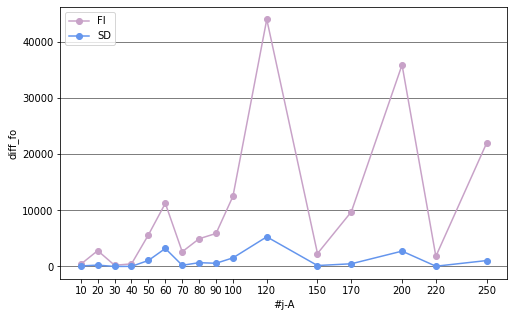

In [20]:
plot(df1["#j-A"], df1["diff_fo"], df2["diff_fo"], "FI", "SD")

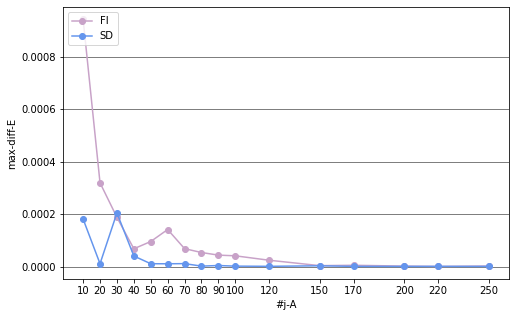

In [21]:
plot(df1["#j-A"], df1["max-diff-E"], df2["max-diff-E"], "FI", "SD")

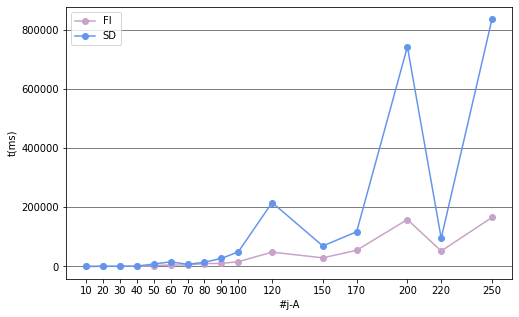

In [22]:
plot(df1["#j-A"], df1["t(ms)"], df2["t(ms)"], "FI", "SD")